In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import epicycloid_process_data as epd
import epicycloid_gd as egd

## Helper functions for plotting

In [3]:
def plot_3d_data(data, ax, color):
    ax.plot(data[:,0], data[:,1], data[:,2],color)
    
def plot_x_y(ax, timestamps, data, name):
    ax.set_title(name)
    ax.plot(timestamps, data[:,0], label="x(t)")
    ax.plot(timestamps, data[:,1], label="y(t)")
    ax.set_xlabel("time")
    ax.legend()
    
def plot_fits(ax, flat_data, timestamps, params, name):
    ax.set_title(name)
    ax.plot(timestamps, flat_data[:,0], "b", label="true x")
    ax.plot(timestamps, flat_data[:,1], "r", label="true y")
    ax.plot(timestamps, egd.epi_x(timestamps, params), "--b", label="fit x")
    ax.plot(timestamps, egd.epi_y(timestamps, params), "--r", label="fit y")
    ax.set_xlabel("Time")
    ax.legend()
    
def plot_2d_fits(ax, flat_data, timestamps, params, name):
    x_pred = egd.epi_x(timestamps, params)
    y_pred = egd.epi_y(timestamps, params)
    
    ax.set_title(name)
    ax.plot(flat_data[:,0], flat_data[:,1], label="true")
    ax.plot(x_pred, y_pred, label="fit")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    
def plot_3D_fit(ax, data, params, normal, name):
    data_true = data[0]
    timestamps = data[2]
    
    data_pred = egd.predict(timestamps, params, normal)
    mse = egd.calc_mse(data_true, data_pred)
    
    print(name, "mse =", mse, "miles")
    
    ax.set_title(name)
    ax.plot(data_true[:,0], data_true[:,1], data_true[:,2], label="Ground Truth")
    ax.plot(data_pred[:,0], data_pred[:,1], data_pred[:,2],label="Prediction")
    ax.legend()

# Pre-process Data

In [11]:
def prune(true_data, flat_data, timestamps, idx1, idx2):
    """
    Take only the data from index1 to index2
    """
    return true_data[idx1:idx2,:], flat_data[idx1:idx2,:], timestamps[idx1:idx2]

In [4]:
mercury_true, mercury_normal, mercury_flat, mercury_timestamps = epd.pre_process_data("data/Mercury4x.csv")
mars_true, mars_normal, mars_flat, mars_timestamps = epd.pre_process_data("data/Mars2x.csv")
jupiter_true, jupiter_normal, jupiter_flat, jupiter_timestamps = epd.pre_process_data("data/Jupiter4x.csv")
venus_true, venus_normal, venus_flat, venus_timestamps = epd.pre_process_data("data/Venus2x.csv")

mercury_train = prune(mercury_true, mercury_flat, mercury_timestamps, 0, len(mercury_timestamps)//2)
venus_train = prune(venus_true, venus_flat, venus_timestamps, 0, len(venus_timestamps)//8)
mars_train = prune(mars_true, mars_flat, mars_timestamps, 0, len(mars_timestamps)//8)
jupiter_train = prune(jupiter_true, jupiter_flat, jupiter_timestamps, 0, len(jupiter_timestamps)//2)

mercury_test = prune(mercury_true, mercury_flat, mercury_timestamps, len(mercury_timestamps)//2, len(mercury_timestamps))
venus_test = prune(venus_true, venus_flat, venus_timestamps, len(venus_timestamps)//8, 2*len(venus_timestamps)//8)
mars_test = prune(mars_true, mars_flat, mars_timestamps, len(mars_timestamps)//8, 2*len(venus_timestamps)//8)
jupiter_test = prune(jupiter_true, jupiter_flat, jupiter_timestamps, len(jupiter_timestamps)//2, len(jupiter_timestamps))

# Reduce Dimensionality of the data
Notes:
- We reduce the dimensionality of the data by finding the orbit's normal vector and then rotating it such that it aligns with the z-axis.
- The z-axis alignment was already done in the pre_process_data function which is why the code is not seen here


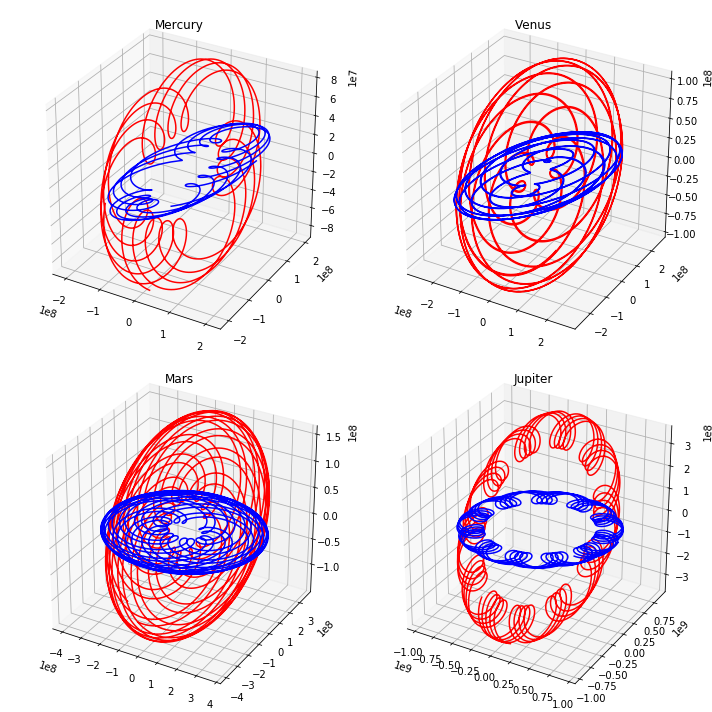

In [5]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

ax1.set_title("Mercury")
plot_3d_data(mercury_true, ax1, 'r')
plot_3d_data(mercury_flat, ax1, 'b')

ax2.set_title("Venus")
plot_3d_data(venus_true, ax2, 'r')
plot_3d_data(venus_flat, ax2, 'b')

ax3.set_title("Mars")
plot_3d_data(mars_true, ax3, 'r')
plot_3d_data(mars_flat, ax3, 'b')

ax4.set_title("Jupiter")
plot_3d_data(jupiter_true, ax4, 'r')
plot_3d_data(jupiter_flat, ax4, 'b')

plt.tight_layout()
plt.show()

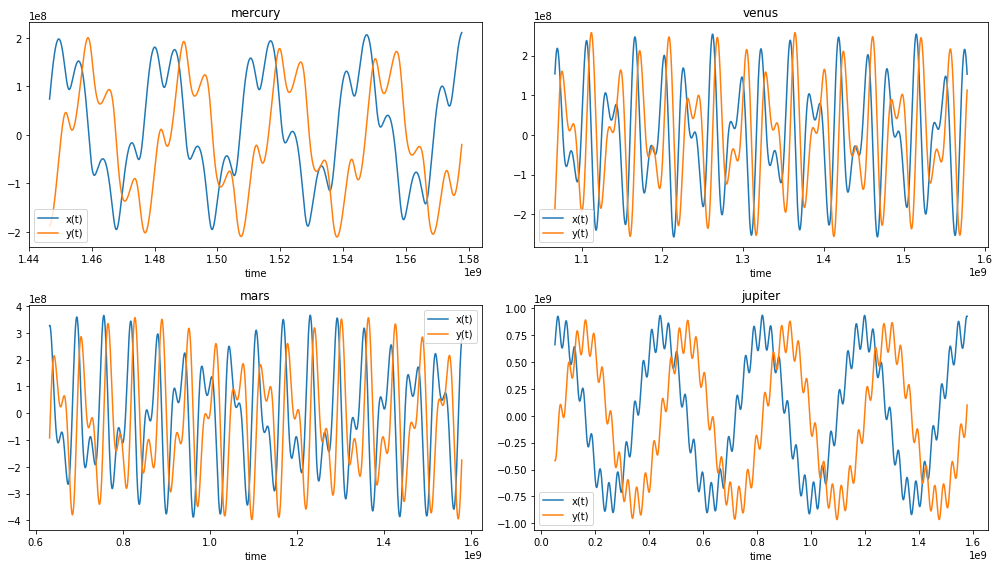

In [6]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

plot_x_y(ax1, mercury_timestamps, mercury_flat, "mercury")
plot_x_y(ax2, venus_timestamps, venus_flat, "venus")
plot_x_y(ax3, mars_timestamps, mars_flat, "mars")
plot_x_y(ax4, jupiter_timestamps, jupiter_flat, "jupiter")

plt.tight_layout()
plt.show()

# Producing the fits
Notes: 
- Fits only worked well when we trained on 2 periods of data
- All graphs and plots are two dimensional because we rotated our data to zero out the z-components

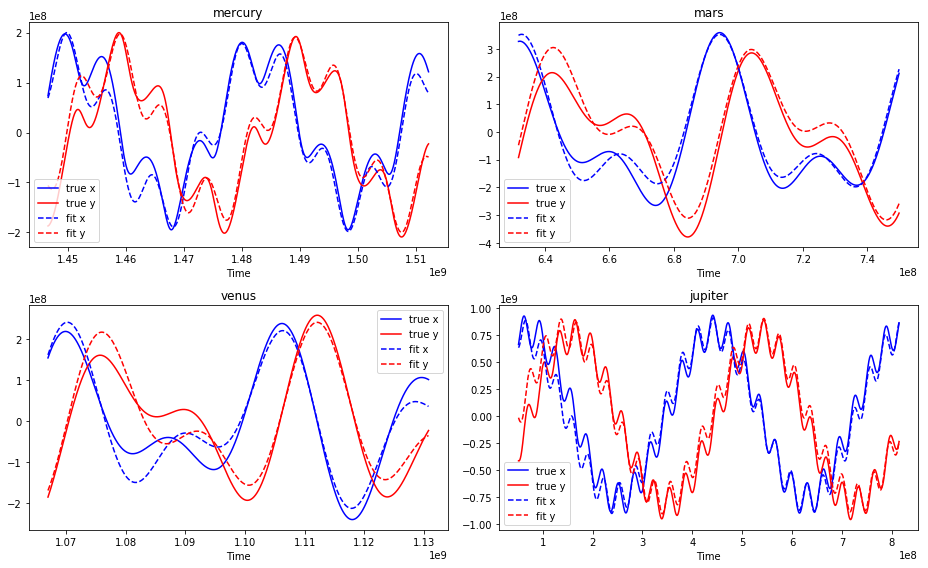

In [7]:
fig = plt.figure(figsize=(13,8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

mercury_params = egd.fit(mercury_train[1], mercury_train[2], period=2, ab_ratio=3.01)
venus_params = egd.fit(venus_train[1], venus_train[2], period=2, ab_ratio=0.55)
mars_params = egd.fit(mars_train[1], mars_train[2], period=2, ab_ratio=0.9)
jupiter_params = egd.fit(jupiter_train[1], jupiter_train[2], period=2, ab_ratio=11.1)

plot_fits(ax1, mercury_train[1], mercury_train[2], mercury_params, "mercury")
plot_fits(ax3, venus_train[1], venus_train[2], venus_params, "venus")
plot_fits(ax2, mars_train[1], mars_train[2], mars_params, "mars")
plot_fits(ax4, jupiter_train[1], jupiter_train[2], jupiter_params, "jupiter")

plt.tight_layout()
plt.show()

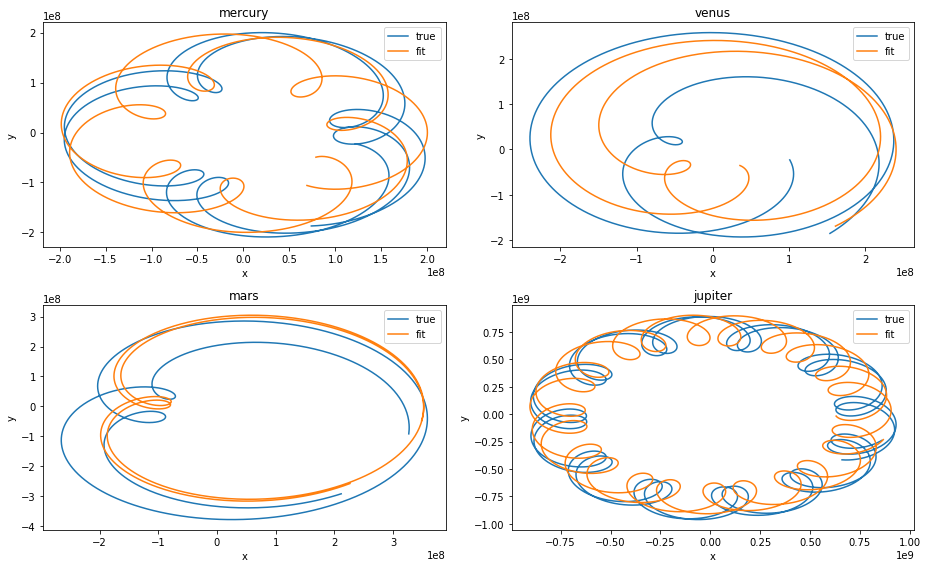

In [8]:
fig = plt.figure(figsize=(13,8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

plot_2d_fits(ax1, mercury_train[1], mercury_train[2], mercury_params, "mercury")
plot_2d_fits(ax2, venus_train[1], venus_train[2], venus_params, "venus")
plot_2d_fits(ax3, mars_train[1], mars_train[2], mars_params, "mars")
plot_2d_fits(ax4, jupiter_train[1], jupiter_train[2], jupiter_params, "jupiter")

plt.tight_layout()
plt.show()

Mercury mse = 2013912440624901.2 miles
Mars mse = 3490473051312266.0 miles
Venus mse = 2604384182388012.0 miles
Jupiter mse = 2.2423833943336868e+16 miles


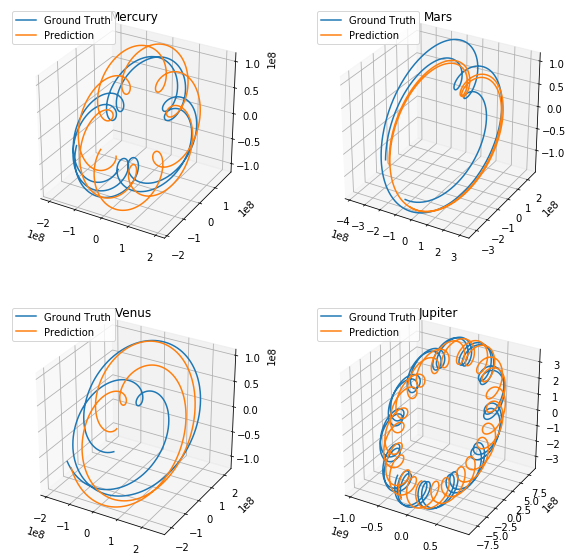

In [9]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

plot_3D_fit(ax1, mercury_train, mercury_params, mercury_normal, "Mercury")
plot_3D_fit(ax2, mars_train, mars_params, mars_normal, "Mars")
plot_3D_fit(ax3, venus_train, venus_params, venus_normal, "Venus")
plot_3D_fit(ax4, jupiter_train, jupiter_params, jupiter_normal, "Jupiter")

plt.show()

# Prediction
Notes:
- We will demonstrate our algorithms'prediction of same planets we trained on
- The MSE's appear to be very high but the average euclidian distance between points are on the same order of magnitude as the planet positions themselves.
- Our Algorithm fails to accurately capture the positions, however it does a very good job with predicting the shape of the orbit

Mercury mse = 7220895668630738.0 miles
Mars mse = 2.1399445372428096e+16 miles
Venus mse = 1.9433198513226884e+16 miles
Jupiter mse = 1.1723149102781109e+17 miles


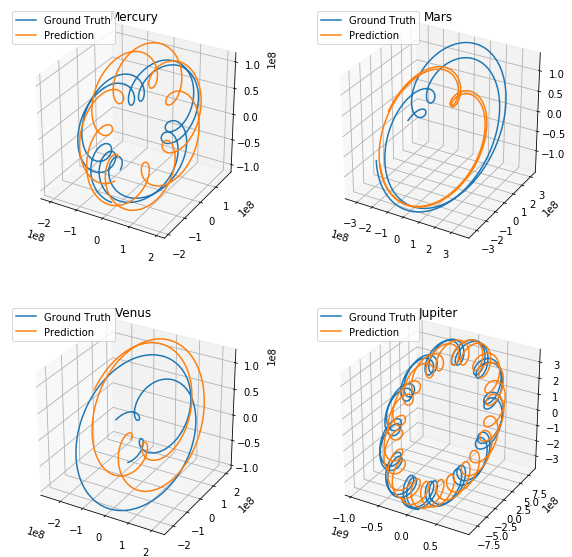

In [10]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

plot_3D_fit(ax1, mercury_test, mercury_params, mercury_normal, "Mercury")
plot_3D_fit(ax2, mars_test, mars_params, mars_normal, "Mars")
plot_3D_fit(ax3, venus_test, venus_params, venus_normal, "Venus")
plot_3D_fit(ax4, jupiter_test, jupiter_params, jupiter_normal, "Jupiter")

plt.show()